In [ ]:
import pandas as pd

# Đường dẫn file CSV trên local
csv_file = r"Dataset\data_integrated.csv"

# Đọc file CSV
df = pd.read_csv(csv_file)

# Xem trước dữ liệu
print(df.head())


   unique_id        date   warehouse  total_orders  sales  sell_price_main  \
0       4845  2024-03-10  Budapest_1        6436.0  16.34           646.26   
1       4845  2021-05-25  Budapest_1        4663.0  12.63           455.96   
2       4845  2021-12-20  Budapest_1        6507.0  34.55           455.96   
3       4845  2023-04-29  Budapest_1        5463.0  34.52           646.26   
4       4845  2022-04-01  Budapest_1        5997.0  35.92           486.41   

   availability  max_discount  product_unique_id          name  \
0          1.00       0.15312               2375  Croissant_35   
1          1.00       0.15025               2375  Croissant_35   
2          1.00       0.15025               2375  Croissant_35   
3          0.96       0.20024               2375  Croissant_35   
4          1.00       0.15649               2375  Croissant_35   

                  category holiday_name  holiday  shops_closed  \
0  Bakery_L2_18_L3_83_L4_1  Non-holiday        0             0   
1 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu
data = pd.read_csv(csv_file)

# Sắp xếp theo ngày
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['unique_id', 'date'])

# Chọn các cột cần thiết
columns_to_scale = ['total_orders', 'sell_price_main', 'availability', 'max_discount', 'sales']
scaler = MinMaxScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Lưu ý: Giữ lại scaler để đảo ngược giá trị sau khi dự đoán.

In [ ]:
# Hàm tạo chuỗi thời gian từ dữ liệu
def create_sequences(data, target_col, sequence_length=30):
    """
    Tạo chuỗi thời gian (sequence) từ dữ liệu.

    Args:
        data (pd.DataFrame): Dữ liệu input chứa các cột làm đặc trưng.
        target_col (int): Vị trí cột mục tiêu (target) trong dataframe.
        sequence_length (int): Độ dài của chuỗi.

    Returns:
        X (np.ndarray): Mảng các chuỗi thời gian.
        y (np.ndarray): Mảng các giá trị mục tiêu tương ứng.
    """
    X, y = [], []
    if len(data) < sequence_length:
        return None, None  # Không đủ dữ liệu để tạo chuỗi
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length, target_col])
    return np.array(X), np.array(y)


In [ ]:
# Áp dụng cho từng sản phẩm
unique_ids = data['unique_id'].unique()
sequence_length = 30  # Sử dụng 30 ngày làm chuỗi
print(f"Number of unique IDs: {len(unique_ids)}")

Number of unique IDs: 5390


In [ ]:
# Tạo danh sách X và y từ từng unique_id
X_list, y_list = [], []

for unique_id in unique_ids:
    subset = data[data['unique_id'] == unique_id]
    X, y = create_sequences(
        subset[['total_orders', 'sell_price_main', 'availability', 'max_discount', 'sales']],
        target_col=4,
        sequence_length=sequence_length
    )

    # Chỉ thêm vào danh sách nếu X và y hợp lệ
    if X is not None and y is not None:
        if len(X.shape) == 3 and len(y.shape) == 1:  # Kiểm tra số chiều
            X_list.append(X)
            y_list.append(y)


# batch_size = 500
# X_list, y_list = [], []

# for i in range(0, len(unique_ids), batch_size):
#     batch_ids = unique_ids[i:i+batch_size]
#     print(f"Processing batch {i//batch_size + 1}/{len(unique_ids)//batch_size + 1}")

#     for unique_id in batch_ids:
#         subset = data[data['unique_id'] == unique_id]
#         X, y = create_sequences(
#             subset[['total_orders', 'sell_price_main', 'availability', 'max_discount', 'sales']],
#             target_col=4,
#             sequence_length=sequence_length
#         )

#         # Kiểm tra và thêm vào danh sách
#         if X is not None and y is not None:
#             if X.ndim == 3 and y.ndim == 1 and X.shape[0] == y.shape[0]:
#                 X_list.append(X)
#                 y_list.append(y)

#     # Xử lý gộp tạm sau mỗi batch để tránh RAM bị đầy
#     if len(X_list) > 0 and len(y_list) > 0:
#         if 'final_X' not in locals():
#             final_X = np.concatenate(X_list, axis=0)
#             final_y = np.concatenate(y_list, axis=0)
#         else:
#             final_X = np.concatenate([final_X, np.concatenate(X_list, axis=0)], axis=0)
#             final_y = np.concatenate([final_y, np.concatenate(y_list, axis=0)], axis=0)

#         # Dọn dẹp RAM
#         X_list, y_list = [], []
#         print(f"Batch {i//batch_size + 1} processed.")

# # Sau khi xử lý xong toàn bộ
# X = final_X
# y = final_y
# print(f"Final shapes: X={X.shape}, y={y.shape}")


In [ ]:
# Kiểm tra lại danh sách sau khi tạo
print(f"Number of valid sequences: {len(X_list)}")
if len(X_list) > 0:
    print(f"Shape of first valid sequence: X={X_list[0].shape}, y={y_list[0].shape}")
else:
    print("No valid sequences found.")

# Gộp tất cả các chuỗi thành một mảng duy nhất
try:
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(f"Final dataset shapes: X={X.shape}, y={y.shape}")
except ValueError as e:
    print(f"Error while concatenating sequences: {e}")
    # Debug từng phần tử trong danh sách nếu có lỗi
    for i, (X_seq, y_seq) in enumerate(zip(X_list, y_list)):
        print(f"Index {i}: X shape: {X_seq.shape}, y shape: {y_seq.shape}")

Number of valid sequences: 5180
Shape of first valid sequence: X=(5, 30, 5), y=(5,)
Final dataset shapes: X=(3847908, 30, 5), y=(3847908,)


In [ ]:
# Kiểm tra kích thước dữ liệu sau khi gộp
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (3847908, 30, 5)
Shape of y: (3847908,)


In [ ]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(3078326, 30, 5), y_train=(3078326,)
Test data shape: X_test=(769582, 30, 5), y_test=(769582,)


In [ ]:
print("X_train sau khi chuẩn hóa (5 mẫu đầu):")
print(X_train[:5])  # In ra 5 mẫu đầu tiên của X_train

print("\nX_test sau khi chuẩn hóa (5 mẫu đầu):")
print(X_test[:5])  # In ra 5 mẫu đầu tiên của X_test

X_train sau khi chuẩn hóa (5 mẫu đầu):
[[[2.68135650e-01 8.82747025e-02 8.08080808e-02 0.00000000e+00
   4.55793224e-04]
  [2.66248543e-01 8.82747025e-02 1.00000000e+00 0.00000000e+00
   8.42241584e-03]
  [2.70633291e-01 8.82747025e-02 9.59595960e-01 4.54247509e-01
   6.40739648e-02]
  [2.77571183e-01 8.82747025e-02 5.05050505e-02 4.54247509e-01
   1.61077555e-03]
  [2.77682189e-01 8.82747025e-02 9.69696970e-01 4.54247509e-01
   6.41244809e-02]
  [2.49708609e-01 8.82747025e-02 1.00000000e+00 4.54247509e-01
   5.20522750e-02]
  [2.53704834e-01 8.82747025e-02 1.00000000e+00 4.54247509e-01
   5.45953027e-02]
  [2.72853416e-01 8.82747025e-02 1.00000000e+00 4.54247509e-01
   6.97799908e-02]
  [2.62085808e-01 8.82747025e-02 1.00000000e+00 3.38025896e-01
   4.20902654e-02]
  [2.60309707e-01 8.82747025e-02 1.00000000e+00 0.00000000e+00
   1.35153598e-02]
  [2.79957818e-01 8.82747025e-02 1.00000000e+00 0.00000000e+00
   1.49504770e-02]
  [2.88116779e-01 8.82747025e-02 1.00000000e+00 0.00000000e

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa X (dữ liệu đầu vào) với scaler ban đầu
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Chuẩn hóa y (dữ liệu mục tiêu) với scaler riêng
y_scaler = MinMaxScaler()
y_scaled_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_scaled_test = y_scaler.transform(y_test.reshape(-1, 1))

In [ ]:
print("y_train gốc (5 mẫu đầu):")
print(y_train[:5])  # In ra giá trị gốc của y_train

print("\ny_train sau khi chuẩn hóa (5 mẫu đầu):")
print(y_scaled_train[:5])  # In ra 5 mẫu đầu của y_train sau khi chuẩn hóa

print("\ny_test sau khi chuẩn hóa (5 mẫu đầu):")
print(y_scaled_test[:5])  # In ra 5 mẫu đầu của y_test sau khi chuẩn hóa

y_train gốc (5 mẫu đầu):
[0.01430374 0.01533999 0.0037608  0.00438323 0.00253494]

y_train sau khi chuẩn hóa (5 mẫu đầu):
[[0.04321655]
 [0.0463474 ]
 [0.01136268]
 [0.01324326]
 [0.00765893]]

y_test sau khi chuẩn hóa (5 mẫu đầu):
[[0.00246496]
 [0.00100114]
 [0.00317563]
 [0.00253729]
 [0.00181743]]


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_scaled_train:", y_scaled_train.shape)
print("Shape of y_scaled_test:", y_scaled_test.shape)

Shape of X_train: (3078326, 30, 5)
Shape of X_test: (769582, 30, 5)
Shape of y_scaled_train: (3078326, 1)
Shape of y_scaled_test: (769582, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Phuoc Tien\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Xây dựng mô hình LSTM
model = Sequential()

# Lớp LSTM
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout để tránh overfitting

# Lớp Dense (fully connected layer)
model.add(Dense(units=1))  # Output layer, chỉ có 1 đầu ra là giá trị sales

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Summary mô hình
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 348s 7ms/step - loss: 4.6265e-05 - val_loss: 3.9969e-05
Epoch 2/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 355s 7ms/step - loss: 7.5952e-06 - val_loss: 6.1118e-05
Epoch 3/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 382s 8ms/step - loss: 7.2489e-06 - val_loss: 7.8445e-05
Epoch 4/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 383s 8ms/step - loss: 7.1547e-06 - val_loss: 4.1205e-05
Epoch 5/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 387s 8ms/step - loss: 7.0874e-06 - val_loss: 7.2928e-05
Epoch 6/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 384s 8ms/step - loss: 7.1151e-06 - val_loss: 5.3941e-05
Epoch 7/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 387s 8ms/step - loss: 6.9615e-06 - val_loss: 5.5078e-05
Epoch 8/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 386s 8ms/step - loss: 6.8661e-06 - val_loss: 2.7314e-05
Epoch 9/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 384s 8ms/step - loss: 6.9423e-06 - val_loss: 2.7325e-05
Epoch 10/10
48099/48099 ━━━━━━━━━━━━━━━━━━━━ 371s 8ms/step - loss: 6.9114e-06 - val_loss: 6.7143e-05

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

24050/24050 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - loss: 6.5502e-05
Test Loss: 6.714361370541155e-05


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Thêm dòng này

# Đánh giá mô hình
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_scaled_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_scaled_test, y_pred))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


24050/24050 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
Mean Absolute Error: 0.011551550568085942
Root Mean Squared Error: 0.06120152215265931


In [ ]:
import numpy as np

# Tạo mảng có shape (n_samples, 5) với các giá trị khác ngoài y_pred
y_pred_rescaled = np.zeros((y_pred.shape[0], 5))  # Tạo mảng với 5 features
y_pred_rescaled[:, 0] = y_pred.flatten()  # Chỉ cột đầu tiên chứa giá trị từ y_pred

y_test_rescaled = np.zeros((y_scaled_test.shape[0], 5))  # Tạo mảng với 5 features
y_test_rescaled[:, 0] = y_scaled_test.flatten()  # Chỉ cột đầu tiên chứa giá trị từ y_scaled_test

# Đảo ngược chuẩn hóa
y_pred_rescaled = scaler.inverse_transform(y_pred_rescaled)[:, 0]  # Lấy lại cột đầu tiên
y_test_rescaled = scaler.inverse_transform(y_test_rescaled)[:, 0]  # Lấy lại cột đầu tiên

print("Rescaled y_pred:", y_pred_rescaled[:10])
print("Rescaled y_test:", y_test_rescaled[:10])


Rescaled y_pred: [0.00074539 0.00100564 0.00088067 0.00133829 0.00191122 0.00211215
 0.00203459 0.00183579 0.0010714  0.00053619]
Rescaled y_test: [0.00246496 0.00100114 0.00317563 0.00253729 0.00181743 0.00294945
 0.00313085 0.00130079 0.00160848 0.00102754]


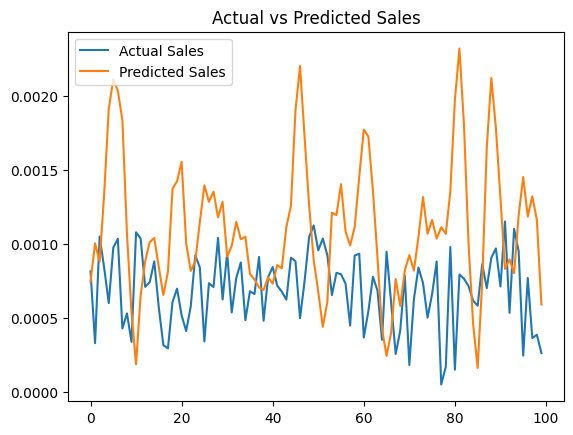

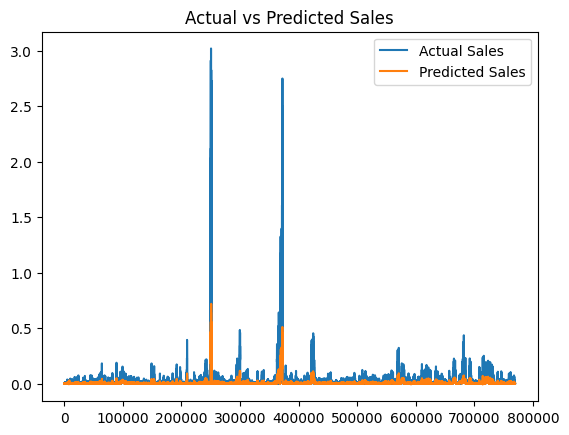

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ so sánh giữa Actual sales và Predicted sales
plt.plot(y_test[:100], label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()


plt.plot(y_test_rescaled[:len(y_pred_rescaled)], label='Actual Sales')
plt.plot(y_pred_rescaled, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()